In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import ot
import cvxpy as cp

# Supplementary Packages
#import scipy.stats as stats
#import seaborn as sns
#import scipy.special as sps
import time as t

## Functions

In [2]:
def baryc_proj(source, target, method):
    
    n1 = source.shape[0]
    n2 = target.shape[0]   
    p = source.shape[1]
    a_ones, b_ones = np.ones((n1,)) / n1, np.ones((n2,)) / n2
    
    M = ot.dist(source, target)
    M = M.astype('float64')
    M /= M.max()
    
    if method == 'emd':
        OTplan = ot.emd(a_ones, b_ones, M, numItermax = 1e7)
        
    elif method == 'entropic':
        OTplan = ot.bregman.sinkhorn_stabilized(a_ones, b_ones, M, reg = 5*1e-3)
    
    # initialization
    OTmap = np.empty((0, p))

    for i in range(n1):
        
        # normalization
        OTplan[i,:] = OTplan[i,:] / sum(OTplan[i,:])
    
        # conditional expectation
        OTmap = np.vstack([OTmap, (target.T @ OTplan[i,:])])
    
    OTmap = np.array(OTmap)
    
    return(OTmap)

In [3]:
def DSCreplicationV2(target, controls, method = 'emd'):
    
    n = target.shape[0]
    d = target.shape[1]
    J = len(controls)
    
    
    # Barycentric Projection
    G_list = []
    proj_list = []
    for i in range(len(controls)):
        temp = baryc_proj(target, controls[i], method)
        G_list.append(temp)
        proj_list.append(temp - target)
    
    
    # Obtain optimal weights
    mylambda = cp.Variable(J)

    objective = cp.Minimize(
                    cp.sum(
                    cp.sum(
                    cp.sum([a*b for a,b in zip(mylambda, proj_list)])**2))/n
                    )
    
    constraints = [mylambda >= 0, mylambda <= 1, cp.sum(mylambda) == 1]

    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    weights = mylambda.value
    replication = sum([a*b for a,b in zip(weights, G_list)])
    
    
    return(weights, replication)

## Medicare Data

In [4]:
def read_medicaid(file_name, sample = False):
    
    columns = ['HINSCAID','EMPSTAT','UHRSWORK','INCWAGE']
    df = pd.read_csv(file_name)[columns]
    
    if sample:
        df = df.sample(5000, random_state = 31)
    
    return(np.array(df))

In [5]:
import os, glob
medidata = []

# check path
for file in glob.glob("workingData/medicaid/*.csv"):
    medidata.append(read_medicaid(file, sample = True))

medidata.insert(0, medidata.pop(12)) # Move Montana to front of list(why is mt 12?)
medi_target = medidata[0]
medi_controls = medidata[1:]

### Test Run

In [6]:
ts = t.time()

weightsm, replicationm = DSCreplicationV2(medi_target, medi_controls)

te = t.time() - ts
# round integer columns
replicationm[:,0:2] = replicationm[:,0:2].round(decimals = 0).astype('int64')

In [7]:
medi_target[0:5,:]

array([[ 1.   ,  1.   , 70.2  ,  7.02 ],
       [ 1.   ,  1.   , 12.3  ,  0.697],
       [ 1.   ,  1.   , 56.4  , 14.1  ],
       [ 1.   ,  1.   , 54.   ,  5.4  ],
       [ 1.   ,  1.   , 33.6  ,  0.864]])

In [8]:
replicationm[0:5,:]

array([[ 1.        ,  1.        , 70.75941701,  7.07132472],
       [ 1.        ,  1.        , 14.27981611,  0.8826316 ],
       [ 1.        ,  1.        , 55.43997101, 15.14927969],
       [ 1.        ,  1.        , 53.92582806,  5.73977124],
       [ 1.        ,  1.        , 32.37516239,  1.1789566 ]])

In [9]:
weightsm

array([ 9.10826920e-02,  3.45208078e-21,  3.98834949e-19,  6.09212215e-20,
        1.02423417e-01, -3.77387613e-20, -2.16713354e-19,  2.56442217e-02,
        1.94299272e-01,  4.04308180e-01,  1.82242216e-01, -1.75489889e-19])

In [10]:
sum(sum((medi_target - replicationm)**2))

44708.70397729079

In [11]:
te

43.87607502937317

## RESULTS

### HINSCAID

In [12]:
5000 - sum(medi_target[:,0] == replicationm[:,0]) ## number of misses

57

### EMPSTAT

In [13]:
5000 - sum(medi_target[:,1] == replicationm[:,1]) ## number of misses

51

### UHRSWORK

(array([3.508e+03, 1.070e+03, 2.690e+02, 8.900e+01, 3.000e+01, 1.400e+01,
        8.000e+00, 8.000e+00, 3.000e+00, 1.000e+00]),
 array([4.30000e-01, 4.68870e+01, 9.33440e+01, 1.39801e+02, 1.86258e+02,
        2.32715e+02, 2.79172e+02, 3.25629e+02, 3.72086e+02, 4.18543e+02,
        4.65000e+02]),
 <BarContainer object of 10 artists>)

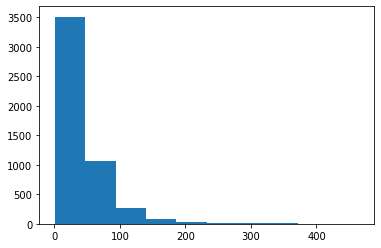

In [14]:
plt.hist(medi_target[:,2])

(array([3.703e+03, 9.610e+02, 2.150e+02, 6.800e+01, 3.100e+01, 1.300e+01,
        6.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([  0.6341669 ,  51.78108364, 102.92800039, 154.07491714,
        205.22183389, 256.36875063, 307.51566738, 358.66258413,
        409.80950088, 460.95641762, 512.10333437]),
 <BarContainer object of 10 artists>)

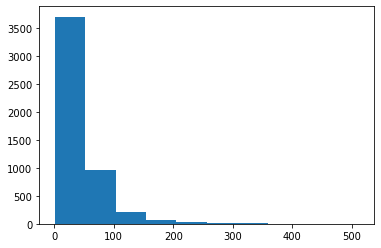

In [15]:
plt.hist(replicationm[:,2])

### INCWAGE

(array([4.743e+03, 2.050e+02, 3.700e+01, 1.100e+01, 2.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  0.    ,  12.8427,  25.6854,  38.5281,  51.3708,  64.2135,
         77.0562,  89.8989, 102.7416, 115.5843, 128.427 ]),
 <BarContainer object of 10 artists>)

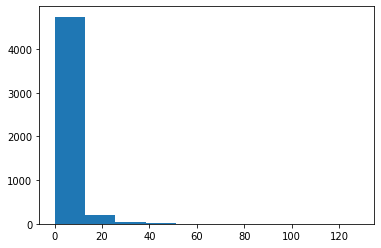

In [16]:
plt.hist(medi_target[:,3])

(array([4.647e+03, 2.670e+02, 4.900e+01, 2.000e+01, 9.000e+00, 4.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([-1.97311700e-19,  1.23377154e+01,  2.46754308e+01,  3.70131462e+01,
         4.93508616e+01,  6.16885770e+01,  7.40262923e+01,  8.63640077e+01,
         9.87017231e+01,  1.11039439e+02,  1.23377154e+02]),
 <BarContainer object of 10 artists>)

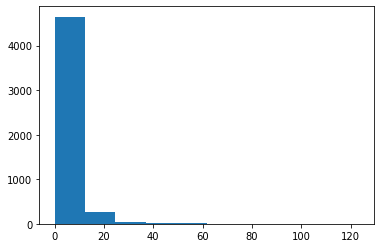

In [17]:
plt.hist(replicationm[:,3])

### Notes:
* This replication was obtained using all 12 controls, all of them sampled without replacement at n=1500.
* I think the replications are quite accurate; they seem to 'preserve the geometry' of the target distributions
* The right tail of the INCWAGE column is not replicated as well. However, the point at the right end are outliers and I feel like all machine learning are prone to this level of error.
* One thing to figure out is when to do the rounding. For this test run, binary columns are rounded after the replication, but I am unsure of the theoretical validity. One option is to round at the barycentric projection step, but in this case, we might have to round once more after we multiply the optimal weights.
* This test run used 1500 observations, and it took 4 seconds to run on my personal laptop. If we were to utilize the GL cluster, I believe we can use even more than 10k observations. And another test run I did with 150 was worse than with 1500, so we might have even better replications with 10k.